# Imports

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

# Data Preprocessing

In [2]:
os.listdir('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/')
df_no_diagnosis = pd.read_csv('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [3]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [4]:
root = 'C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Read Respiratory Cycle Data

In [5]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [6]:
import os
from collections import Counter

# Ścieżka do katalogu z plikami audio
directory_path = "C:/Users/u144572/self_development/final_model/audio_and_txt_files_train_val"

# Pobierz listę plików w katalogu
filenames = [f for f in os.listdir(directory_path) if f.endswith('.wav')]
# print(filenames)

def extract_last_component(filename):
    base_name = os.path.splitext(filename)[0]
    components = base_name.split('_')
    return components[-1]

last_components = [extract_last_component(filename) for filename in filenames]
component_counts = Counter(last_components)

for component, count in component_counts.items():
    print(f"{component}: {count}")

import pandas as pd

df = pd.DataFrame(component_counts.items(), columns=['Component', 'Count'])
print(df)


Meditron: 113
LittC2SE: 77
Litt3200: 56
AKGC417L: 582
  Component  Count
0  Meditron    113
1  LittC2SE     77
2  Litt3200     56
3  AKGC417L    582


In [7]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
root = "C:/Users/u144572/self_development/final_model/audio_and_txt_files_train_val"

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

rec_annotations_dict

{'101_1b1_Al_sc_Meditron':      Start     End  Crackles  Wheezes
 0    0.036   0.579         0        0
 1    0.579   2.450         0        0
 2    2.450   3.893         0        0
 3    3.893   5.793         0        0
 4    5.793   7.521         0        0
 5    7.521   9.279         0        0
 6    9.279  11.150         0        0
 7   11.150  13.036         0        0
 8   13.036  14.721         0        0
 9   14.721  16.707         0        0
 10  16.707  18.507         0        0
 11  18.507  19.964         0        0,
 '102_1b1_Ar_sc_Meditron':      Start     End  Crackles  Wheezes
 0    0.264   1.736         0        0
 1    1.736   3.293         0        0
 2    3.293   5.307         0        0
 3    5.307   6.636         0        0
 4    6.636   8.036         0        0
 5    8.036   9.607         0        0
 6    9.607  11.036         0        0
 7   11.036  13.036         0        0
 8   13.036  14.664         0        0
 9   14.664  16.393         0        0
 10  16.393

## Get Respiratory Cycle length and Diagnosis

In [8]:
res_rate_list = []
for i in range (828):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)

In [9]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])

,Start,End,cycle length,filename
0,8.639333,10.300000,1.660667,101
1,9.807231,11.322615,1.515385,102
2,8.778667,12.047833,3.269167,103
7,10.556215,12.322369,1.766154,104
6,4.569230,7.424760,2.855530,104
...,...,...,...,...
823,9.380857,12.227714,2.846857,224
824,9.587714,11.012214,1.424500,225
826,8.942800,10.927100,1.984300,226
825,8.444400,10.438600,1.994200,226


In [10]:
# Respiratory cycle = Cycle length // 60 seconds 
avg = res_rate_df.groupby('filename').mean()
avg['respiratory_rate'] = 60 / avg['cycle length']
avg['respiratory_rate']

filename
101    36.130068
102    39.593909
103    18.353301
104    26.274026
105    24.155805
         ...    
222    12.113927
223    19.402063
224    21.075873
225    42.120042
226    31.080031
Name: respiratory_rate, Length: 125, dtype: float64

## Save Diagnosis Data

In [11]:
avg.respiratory_rate.to_csv('respiratory_rate_linear.csv')

## Data Augmentation

In [12]:
audio_data =  "C:/Users/u144572/self_development/final_model/audio_and_txt_files_train_val"

In [13]:
rr_diagnosis_df = pd.read_csv('respiratory_rate_linear.csv', names=['patient_id', 'respiratory_rate'],header=0)
rr_diagnosis_df.head(4)

,patient_id,respiratory_rate
0,101,36.130068
1,102,39.593909
2,103,18.353301
3,104,26.274026


In [14]:
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [15]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':

            label = list(data[data['patient_id']==int(soundDir[:3])]['respiratory_rate'])[0]
                
            data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs)
            y_.append(list(data[data['patient_id']==int(soundDir[:3])]['respiratory_rate'])[0])
           
                
    X_data = np.array(X_)
    y_data = np.array(y_)    
    
    return X_data ,y_data

In [16]:
data = rr_diagnosis_df
for soundDir in (os.listdir(audio_data)):
    print(list(data[data['patient_id']==int(soundDir[:3])]['respiratory_rate']))

[36.13006824568447]
[36.13006824568447]
[39.59390862944163]
[39.59390862944163]
[18.35330104511853]
[18.35330104511853]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[26.274026066993805]
[24.155804941875093]
[24.155804941875093]
[27.10639259091936]
[27.10639259091936]
[27.10639259091936]
[27.10639259091936]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34502130143141]
[26.34

[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[17.52461064886776]
[51.81610363220727]
[51.81610363220727]
[45.870629691103495]
[45.870629691103495]
[45.870629691103495]
[45.870629691103495]
[45.870629691103495]
[45.870629691103495]
[15.064778547755347]
[15.064778547755347]
[12.034297748583464]
[12.034297748583464]
[24.13839345581333]
[24.13839345581333]
[24.13839345581333]
[24.138393

In [17]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data + "/")

In [18]:
res_features = np.array(res_data)
res_lables = np.array(res_y)

res_features.shape , res_lables.shape

((828, 50), (828,))

## Data Split

In [19]:
x_train, x_val, y_train, y_val  = train_test_split(res_features, res_lables, test_size=0.175, random_state=10)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)

print (x_train.shape, x_val.shape)
print (y_train.shape, y_val.shape)

(683, 50) (145, 50)
(683,) (145,)


# LSTM Model

In [20]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
# x_test_lstm = np.expand_dims(x_test,axis=2)

## Build Model

In [21]:
# Define the model
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))

model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [22]:
history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=150, validation_data=(x_val_lstm, y_val),
  )
model.save("model.h5") 
model.save_weights('model.weights.h5')
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 568ms/step - loss: 502.5758 - mae: 21.4464 - val_loss: 518.8530 - val_mae: 21.2965
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - loss: 399.3807 - mae: 18.8068 - val_loss: 378.9756 - val_mae: 17.7155
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - loss: 336.7857 - mae: 16.8890 - val_loss: 288.5793 - val_mae: 14.9492
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - loss: 244.5053 - mae: 13.7150 - val_loss: 222.4038 - val_mae: 12.5423
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step - loss: 194.1692 - mae: 11.4092 - val_loss: 171.9478 - val_mae: 10.3941
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - loss: 174.0961 - mae: 10.8263 - val_loss: 136.0875 - val_mae: 8.6925
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - loss: 147.5705 - mae: 9.7878 - val_loss: 118.6809 - val_mae: 7.7662
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 515ms/step - loss: 143.4831 - mae: 9.7337 - val_loss: 109.5924 - val_mae: 7.33

KeyboardInterrupt: 

## Evaluate Model

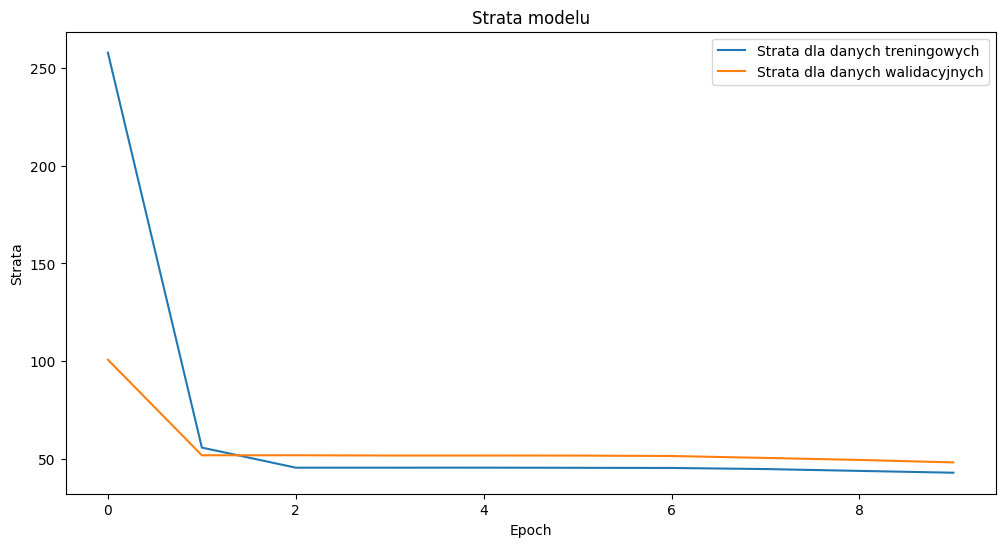

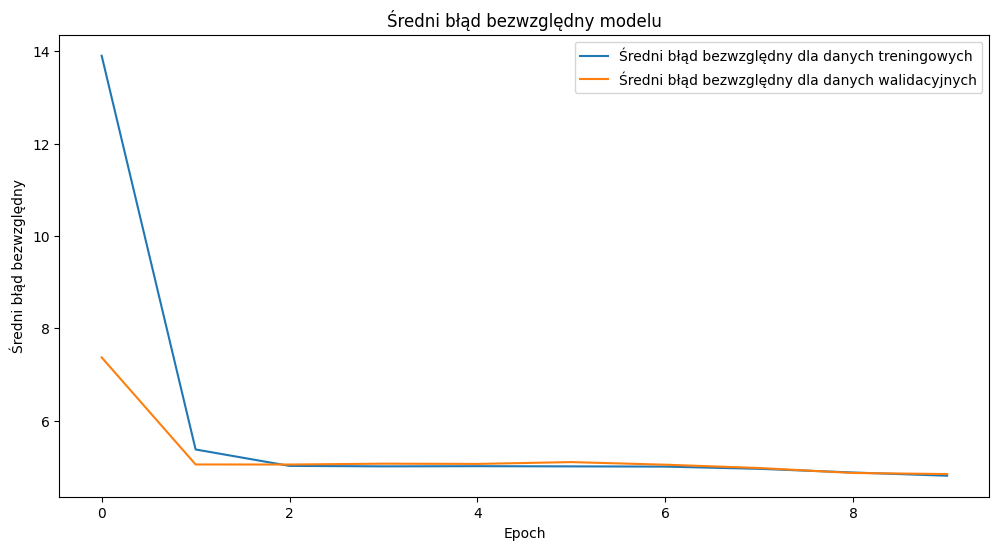

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


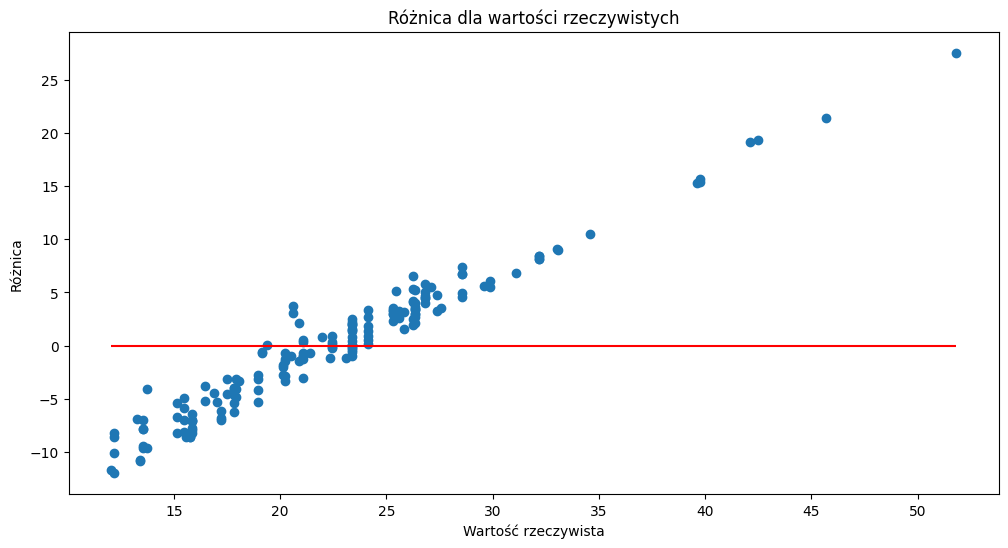

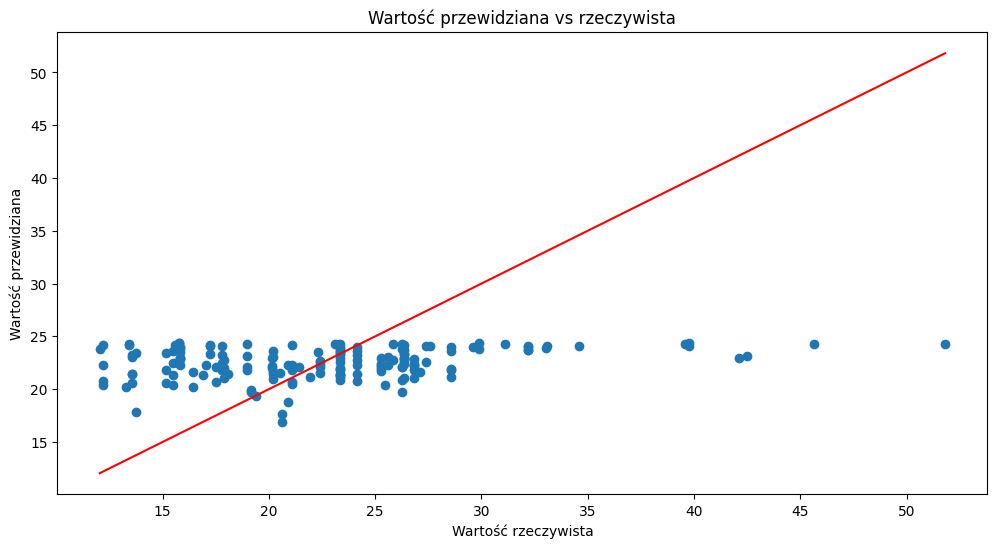

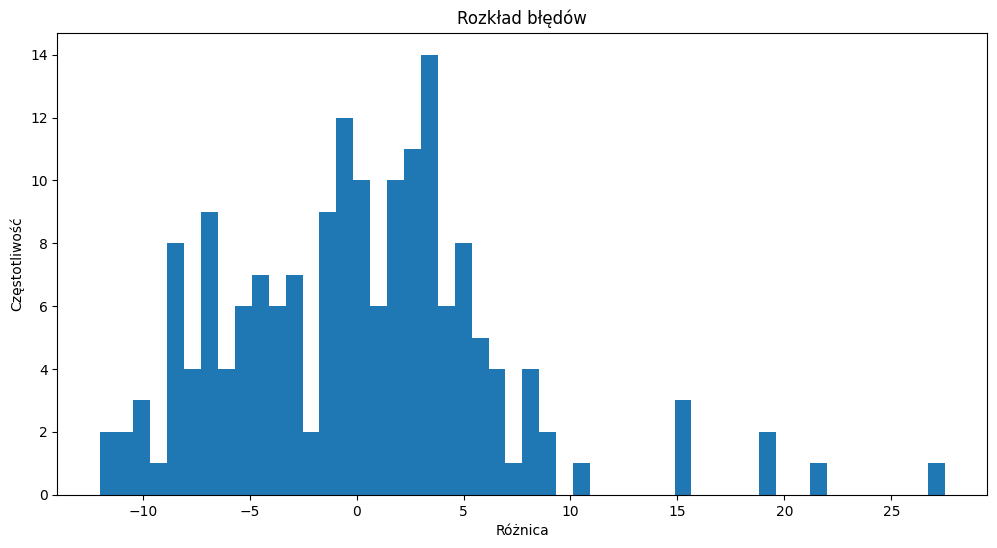

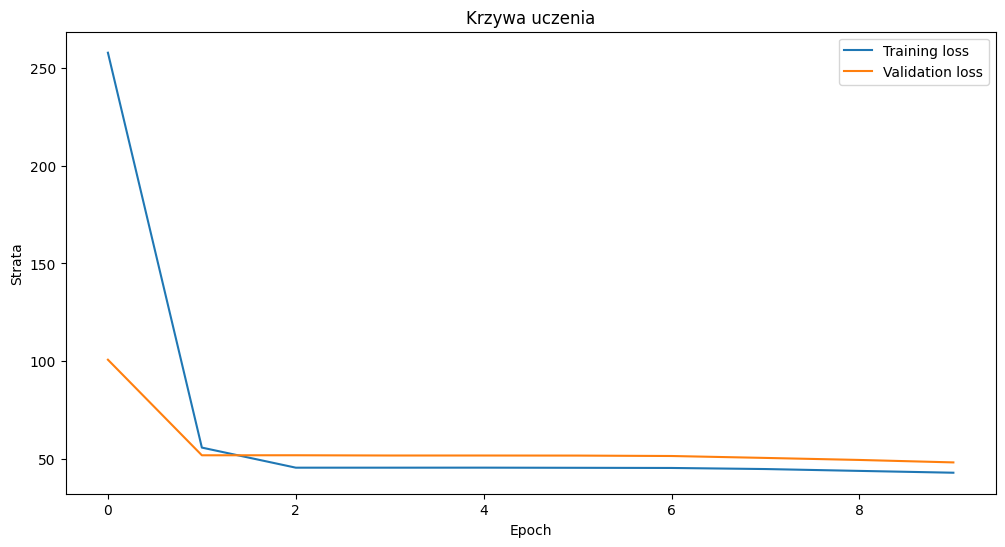

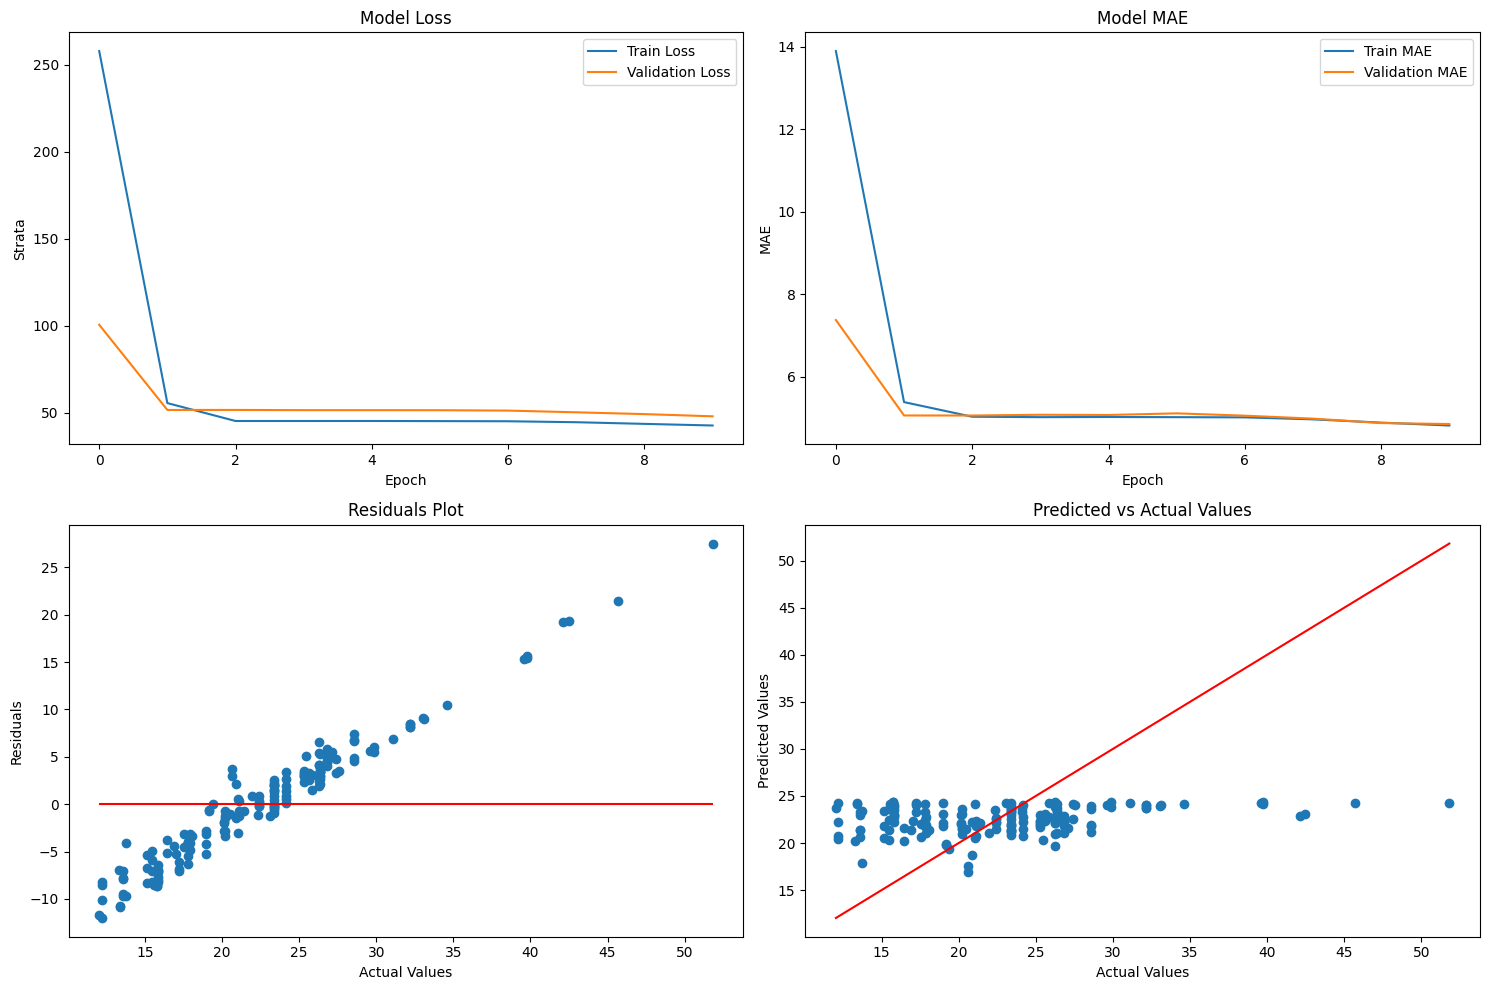

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Strata dla danych treningowych')
plt.plot(history.history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history.history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.show()

In [91]:
# loss, mae = model.evaluate(x_test_lstm, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test MAE: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 43.2983 - mae: 4.9917
Test Loss: 40.79694747924805
Test MAE: 4.819622993469238


In [1]:
import numpy as np
import librosa
from keras.models import load_model

def respiratory_rate_prediction(audio_path):
    # Load audio with 22050 Hz sampling rate
    # data_x, sampling_rate = librosa.load(audio_path, sr=22050)
    data_x, sampling_rate = librosa.load(audio_path, res_type='kaiser_fast')
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features)[0][0]

    print(f'Predicted Respiratory Rate: {predicted_value}')

respiratory_rate_prediction("C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav")

NameError: name 'model' is not defined

In [122]:
res_y[1]

34.5845487415067

In [123]:
rr_diagnosis_df

,patient_id,respiratory_rate
0,101,34.584549
1,102,39.593909
2,103,18.353301
3,104,26.274026
4,105,24.155805
...,...,...
121,222,12.113927
122,223,19.402063
123,224,21.060549
124,225,42.120042


In [4]:
import os
import wave

def get_wav_duration(file_path):
    """Returns the duration of a wav file in seconds."""
    with wave.open(file_path, 'r') as wav_file:
        frames = wav_file.getnframes()
        rate = wav_file.getframerate()
        duration = frames / float(rate)
        return duration

def total_wav_duration(directory):
    """Calculates the total duration of all wav files in a directory."""
    total_duration = 0.0
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            duration = get_wav_duration(file_path)
            total_duration += duration
            print(f"{filename}: {duration:.2f} seconds")
    return total_duration

if __name__ == "__main__":
    total_duration = total_wav_duration("C:/Users/u144572/self_development/ml_method_kaggle/own_data/")
    print(f"\nTotal duration of all wav files: {total_duration:.2f} seconds")


10(1).wav: 34.73 seconds
10(2).wav: 23.77 seconds
10(3).wav: 34.73 seconds
10.wav: 22.89 seconds
11 normalnie.wav: 31.45 seconds
11.wav: 22.36 seconds
12 normalnie.wav: 31.47 seconds
13.wav: 22.42 seconds
18(1).wav: 61.67 seconds
18.wav: 29.82 seconds
4(1).wav: 22.93 seconds
4.wav: 22.93 seconds
5.wav: 20.95 seconds
5_1_.wav: 20.89 seconds
5_2_.wav: 20.95 seconds
6 glebokie.wav: 35.37 seconds
6(1).wav: 22.85 seconds
6.wav: 27.95 seconds
7.wav: 25.32 seconds
8.wav: 20.54 seconds
9(1).wav: 27.52 seconds
9.wav: 25.79 seconds
gabi_13.wav: 26.45 seconds
iza_10.wav: 27.90 seconds
Janowska_6.wav: 18.13 seconds
Janowska_9.wav: 32.32 seconds
Jddd_7.wav: 17.90 seconds
Jdd_5.wav: 13.50 seconds
Jdd_6.wav: 14.87 seconds
Jdd_7.wav: 17.84 seconds
Jd_11.wav: 34.35 seconds
Jd_5.wav: 13.39 seconds
Jd_7.wav: 13.69 seconds
jd_8.wav: 27.87 seconds
nn_5(1).wav: 23.36 seconds
nn_5(2).wav: 23.36 seconds
nn_6.wav: 25.32 seconds
nn_7.wav: 26.26 seconds
nos_5.wav: 25.45 seconds
nss_6.wav: 26.05 seconds
ns_6.wav: